<a href="https://colab.research.google.com/github/likhithaap/Car-damage-assesment-deep-learning-/blob/main/damageassesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up Detectron2**

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html


     |████████████████████████████████| 274 kB 8.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=7d165b8107fa0971d60938922f9ceedc9b102cfdfa30e10a5952f8cc709b17c4
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 52.7 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 145 kB 24.2 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 130 kB 50.5 MB/s 
     |████████████████████████████████| 749 kB 44.9 MB/s 
     |██████████████████████████████

In [1]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Loading and registering the dataset to Detectron2

In [2]:
! unzip archive.zip

Archive:  archive.zip
  inflating: img/1.jpg               
  inflating: img/10.jpg              
  inflating: img/13.jpg              
  inflating: img/14.jpg              
  inflating: img/15.jpg              
  inflating: img/16.jpg              
  inflating: img/17.jpg              
  inflating: img/18.jpg              
  inflating: img/19.jpg              
  inflating: img/2.jpg               
  inflating: img/20.jpg              
  inflating: img/21.jpg              
  inflating: img/22.jpg              
  inflating: img/23.jpg              
  inflating: img/24.jpg              
  inflating: img/25.jpg              
  inflating: img/26.jpg              
  inflating: img/27.jpg              
  inflating: img/29.jpg              
  inflating: img/3.jpg               
  inflating: img/30.jpg              
  inflating: img/31.jpg              
  inflating: img/32.jpg              
  inflating: img/33.jpg              
  inflating: img/34.jpg              
  inflating: img/36.jpg     

In [3]:
#setting variables for all paths in the dataset 
#dataset_dir = "../input/coco-car-damage-detection-dataset"
img_dir = "/content/img"
train_dir = "/content/train"
val_dir = "/content/val"

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/COCO_train_annos.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/val/COCO_val_annos.json", "/content/val")

In [5]:
dataset_dicts = DatasetCatalog.get("my_dataset_train")
metadata_dicts = MetadataCatalog.get("my_dataset_train")

[03/07 17:06:20 d2.data.datasets.coco]: Loaded 59 images in COCO format from /content/train/COCO_train_annos.json


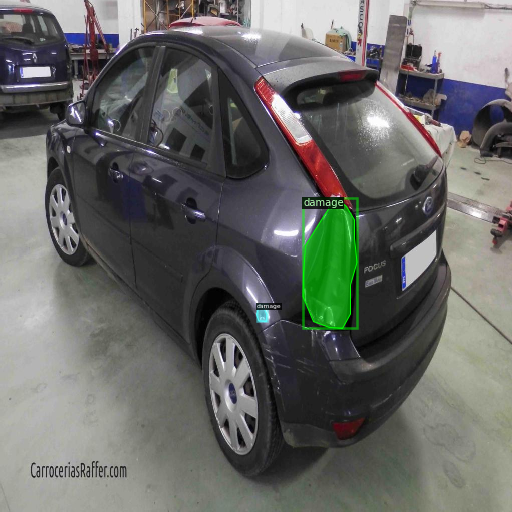

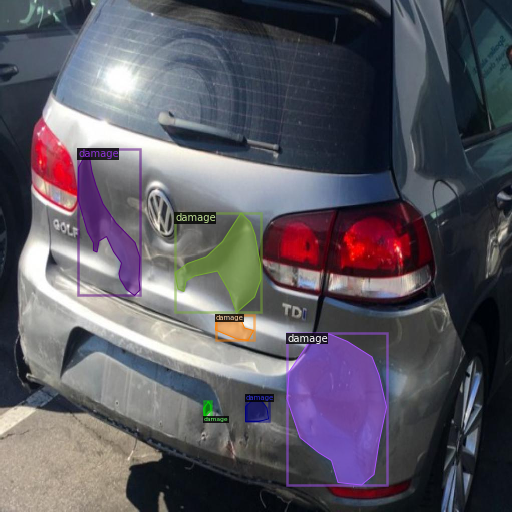

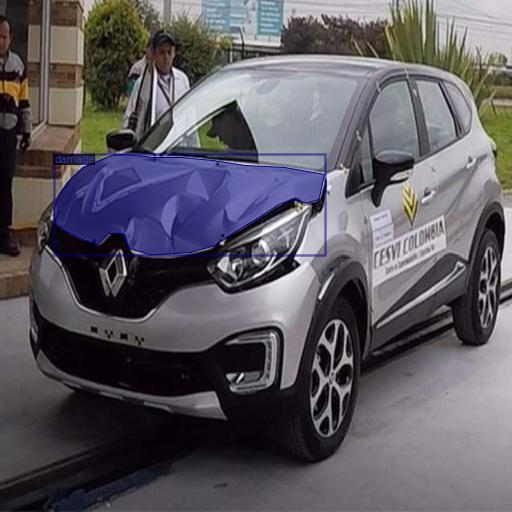

In [6]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_dicts, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [7]:
from detectron2 import model_zoo
import os

In [11]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001 # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/07 17:31:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in th

[03/07 17:31:43 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[03/07 17:32:03 d2.utils.events]:  eta: 0:08:08  iter: 19  total_loss: 2.57  loss_cls: 1.237  loss_box_reg: 0.3457  loss_mask: 0.6939  loss_rpn_cls: 0.1686  loss_rpn_loc: 0.02093  time: 0.9995  data_time: 0.0314  lr: 3.8962e-05  max_mem: 2364M
[03/07 17:32:22 d2.utils.events]:  eta: 0:07:44  iter: 39  total_loss: 1.936  loss_cls: 0.644  loss_box_reg: 0.404  loss_mask: 0.6802  loss_rpn_cls: 0.1554  loss_rpn_loc: 0.02051  time: 0.9813  data_time: 0.0103  lr: 7.8922e-05  max_mem: 2364M
[03/07 17:32:42 d2.utils.events]:  eta: 0:07:22  iter: 59  total_loss: 1.624  loss_cls: 0.4456  loss_box_reg: 0.3898  loss_mask: 0.6545  loss_rpn_cls: 0.07083  loss_rpn_loc: 0.01637  time: 0.9854  data_time: 0.0093  lr: 0.00011888  max_mem: 2364M
[03/07 17:33:02 d2.utils.events]:  eta: 0:07:02  iter: 79  total_loss: 1.546  loss_cls: 0.3962  loss_box_reg: 0.4281  loss_mask: 0.6106  loss_rpn_cls: 0.0609  loss_rpn_loc: 0.01876  time: 0.9876  data_time: 0.0083  lr: 0.00015884  max_mem: 2364M
[03/07 17:33:22 d2.